# Downscaling Temperature at 2m for **Manhattan**

**Variables:**
* Variable to be downscaled: Temperature at 2 meters (T2)
* Predictor variable: Surface Pressure (PSFC) 

**Dataset Resolutions:**
* uWRF (Domain 02): 3-hourly, 3 km
* NAM: 3-hourly, 12 km

**Spatial Coverage:**
* 2,205.41 km²

# Import libraries

In [1]:
import xarray as xr
import numpy as np
import ecubevis as ecv
import scipy as sp
import netCDF4 as nc
import dl4ds as dds
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import models
import pandas as pd
import os

2025-01-24 16:43:04.093145: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-24 16:43:04.173202: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-24 16:43:04.174703: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-24 16:43:08.381065: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
!python --version

Python 3.8.18


# Define paths and retrieve files from server

In [3]:
uwrf_train = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/pred-NYC-split/train/uWRF_final_01-02.nc')
uwrf_val = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/pred-NYC-split/val/uWRF_final_03.nc')
uwrf_test = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/pred-NYC-split/test/uWRF_final_03.nc')

nam_train = xr.open_dataset('/home/gvaillant1/downscaling/data/T2-NYC-data/aligned_nam_train_data.nc')
nam_val = xr.open_dataset('/home/gvaillant1/downscaling/data/T2-NYC-data/aligned_nam_val_data.nc')
nam_test = xr.open_dataset('/home/gvaillant1/downscaling/data/T2-NYC-data/aligned_nam_test_data.nc')

# Using different visualization tool and calculating spatial coverage

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


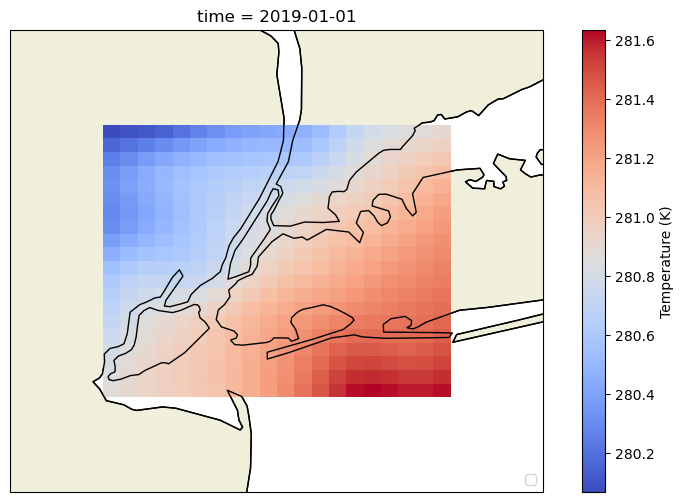

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the dataset
uwrf_train = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/pred-NYC-split/train/uWRF_final_01-02.nc')

# Extract T2 for the first timestep
t2_first = uwrf_train['T2'].isel(time=0)

# Get spatial coverage
uwrf_min_lat = t2_first['latitude'].values.min()
uwrf_max_lat = t2_first['latitude'].values.max()
uwrf_min_lon = t2_first['longitude'].values.min()
uwrf_max_lon = t2_first['longitude'].values.max()

# Plotting with Cartopy
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_title("uWRF Dataset Coverage and T2 Field (First Time Step)", fontsize=14)

# Add coastlines and features
ax.coastlines(resolution='10m', color='black', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS)

# Plot T2 data
t2_first.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', cbar_kwargs={'label': 'Temperature (K)'})

# Add bounding box
"""
ax.plot(
    [uwrf_min_lon, uwrf_min_lon, uwrf_max_lon, uwrf_max_lon, uwrf_min_lon],
    [uwrf_min_lat, uwrf_max_lat, uwrf_max_lat, uwrf_min_lat, uwrf_min_lat],
    color='red', transform=ccrs.PlateCarree(), linewidth=2, label='uWRF Coverage'
)
"""
# Set extent for the map
ax.set_extent([uwrf_min_lon - 0.2, uwrf_max_lon + 0.2, uwrf_min_lat - 0.2, uwrf_max_lat + 0.2])

# Add legend
ax.legend(loc='lower right')

plt.show()


In [5]:
import numpy as np

uwrf_min_lat = min(uwrf_train['latitude'].values)
uwrf_max_lat = max(uwrf_train['latitude'].values)
uwrf_min_lon = min(uwrf_train['longitude'].values)
uwrf_max_lon = max(uwrf_train['longitude'].values)

nam_min_lat = min(nam_train['latitude'].values)
nam_max_lat = max(nam_train['latitude'].values)
nam_min_lon = min(nam_train['longitude'].values)
nam_max_lon = max(nam_train['longitude'].values)

def calculate_area(min_lat, max_lat, min_lon, max_lon):
    # Earth's radius in km
    R = 6371

    # Convert degrees to radians
    min_lat_rad = np.radians(min_lat)
    max_lat_rad = np.radians(max_lat)
    min_lon_rad = np.radians(min_lon)
    max_lon_rad = np.radians(max_lon)

    # Calculate differences
    delta_lat = max_lat_rad - min_lat_rad
    delta_lon = max_lon_rad - min_lon_rad

    # Area of a spherical rectangle segment
    area = (R**2) * delta_lon * (np.sin(max_lat_rad) - np.sin(min_lat_rad))
    return abs(area)

# uWRF area
uwrf_area = calculate_area(uwrf_min_lat, uwrf_max_lat, uwrf_min_lon, uwrf_max_lon)
print(f"uWRF Area: {uwrf_area:.2f} km²")

# NAM area
nam_area = calculate_area(nam_min_lat, nam_max_lat, nam_min_lon, nam_max_lon)
print(f"NAM Area: {nam_area:.2f} km²")

# Intersection area
intersection_area = calculate_area(
    max(uwrf_min_lat, nam_min_lat),
    min(uwrf_max_lat, nam_max_lat),
    max(uwrf_min_lon, nam_min_lon),
    min(uwrf_max_lon, nam_max_lon),
)
if intersection_area > 0:
    print(f"Intersection Area: {intersection_area:.2f} km²")
else:
    print("No overlap between the datasets.")


uWRF Area: 3106.96 km²
NAM Area: 2205.41 km²
Intersection Area: 2205.41 km²


# Define variables

In [6]:
#High resolution (uWRF) data
T2_hr_train = uwrf_train.T2
T2_hr_val = uwrf_val.T2
T2_hr_test = uwrf_test.T2

PSFC_hr_train = uwrf_train.PSFC
PSFC_hr_val = uwrf_val.PSFC
PSFC_hr_test = uwrf_test.PSFC

#--------------------------
#Low resolution (NAM) data
T2_lr_train = nam_train.T2
T2_lr_val = nam_val.T2
T2_lr_test = nam_test.T2

PSFC_lr_train = nam_train.PSFC
PSFC_lr_val = nam_val.PSFC
PSFC_lr_test = nam_test.PSFC

# Scale the data

In [8]:
T2_scaler_train = dds.StandardScaler(axis=None)
T2_scaler_train.fit(T2_hr_train)  

PSFC_scaler_train = dds.StandardScaler(axis=None)
PSFC_scaler_train.fit(PSFC_hr_train)
#----------------------------------------------
#High resolution (uWRF):
y_train = T2_scaler_train.transform(T2_hr_train)
y_val = T2_scaler_train.transform(T2_hr_val)
y_test = T2_scaler_train.transform(T2_hr_test)


y_z_train = PSFC_scaler_train.transform(PSFC_hr_train)
y_z_val = PSFC_scaler_train.transform(PSFC_hr_val)
y_z_test = PSFC_scaler_train.transform(PSFC_hr_test)

#-------------------------------------------------
#Low resolution (NAM)

x_train = T2_scaler_train.transform(T2_lr_train)
x_val = T2_scaler_train.transform(T2_lr_val)
x_test = T2_scaler_train.transform(T2_lr_test)

x_z_train = PSFC_scaler_train.transform(PSFC_lr_train)
x_z_val = PSFC_scaler_train.transform(PSFC_lr_val)
x_z_test = PSFC_scaler_train.transform(PSFC_lr_test)


# Compare original resolutions

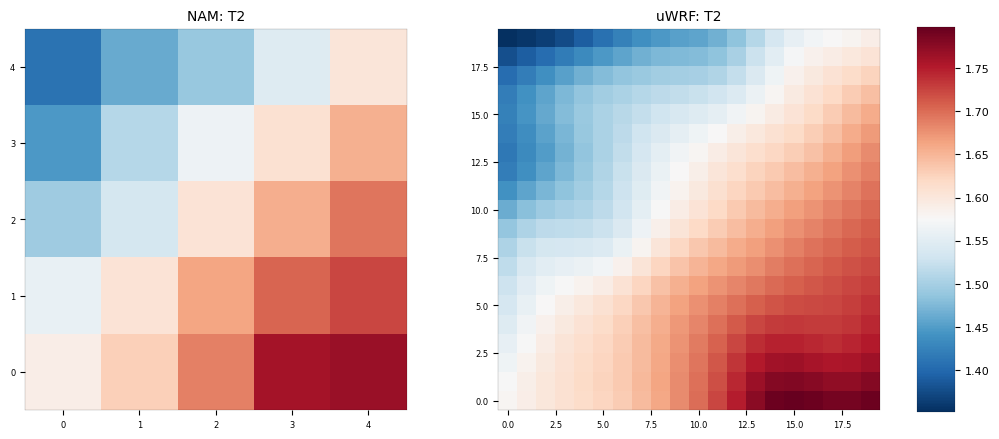

In [9]:
#T2: Temperature at 2 meters
ecv.plot((x_train[0].values, y_train[0]), share_colorbar=True, share_dynamic_range=True, subplot_titles=('NAM: T2', 'uWRF: T2'))

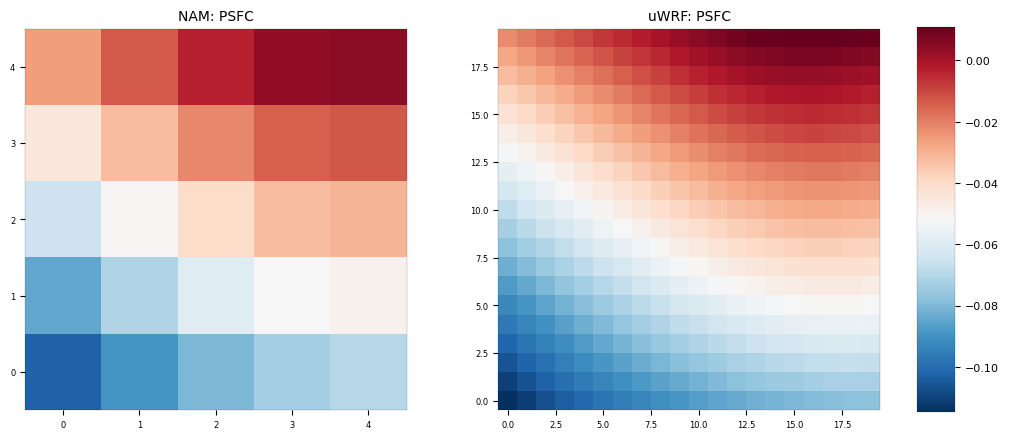

In [10]:
#PSFC: Surface Pressure
ecv.plot((x_z_train[0].values, y_z_train[0]),
         show_coastline=True, share_colorbar=True, share_dynamic_range=True, subplot_titles=('NAM: PSFC', 'uWRF: PSFC'))

# Add channel dimension

In [11]:
y_train = y_train.expand_dims(dim='channel', axis=-1)
y_val = y_val.expand_dims(dim='channel', axis=-1)
y_test = y_test.expand_dims(dim='channel', axis=-1)

y_z_train = y_z_train.expand_dims(dim ='channel', axis=-1)
y_z_val = y_z_val.expand_dims(dim ='channel', axis=-1)
y_z_test = y_z_test.expand_dims(dim ='channel', axis=-1)

#-----------------------------------------------------

x_train = x_train.expand_dims(dim='channel', axis=-1)
x_val = x_val.expand_dims(dim='channel', axis=-1)
x_test = x_test.expand_dims(dim='channel', axis=-1)

x_z_train = x_z_train.expand_dims(dim ='channel', axis=-1)
x_z_val = x_z_val.expand_dims(dim ='channel', axis=-1)
x_z_test = x_z_test.expand_dims(dim ='channel', axis=-1)

# Verify shape

In [12]:
print("T2 hr data shape:")
print(y_train.shape, y_val.shape, y_test.shape)
print("")
print("PSFC hr data shape:")
print(y_z_train.shape, y_z_val.shape, y_z_test.shape)
print("")
print("T2 lr data shape:")
print(x_train.shape, x_val.shape, x_test.shape)
print("")
print("PSFC lr data shape:")
print(x_z_train.shape, x_z_val.shape, x_z_test.shape)

T2 hr data shape:
(1537, 20, 20, 1) (812, 20, 20, 1) (812, 20, 20, 1)

PSFC hr data shape:
(1537, 20, 20, 1) (812, 20, 20, 1) (812, 20, 20, 1)

T2 lr data shape:
(1537, 5, 5, 1) (449, 5, 5, 1) (450, 5, 5, 1)

PSFC lr data shape:
(1537, 5, 5, 1) (449, 5, 5, 1) (450, 5, 5, 1)


In [13]:
type(y_train)

xarray.core.dataarray.DataArray

# Example coarsening method occuring during training:

For this model, we do not use the LR data (NAM) during training. Instead, we use a coarsened version (via interpolation) of the HR (uWRF) T2 and PSFC data. The DL4DS model carries out this interpolation on the fly by using the helper function dds.create_pair_hr_lr() (not to be called by the user). This process is done **automatically** inside the training loop (by calling one of the two (Supervised vs GAN) Trainer classes in DL4DS), which we examplify here with the spc upsampling. 

HR array: (20, 20, 1), LR array (5, 5, 2)


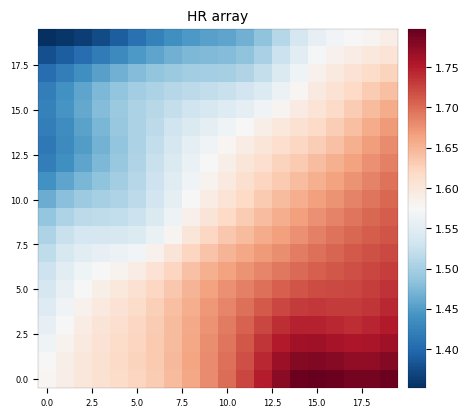

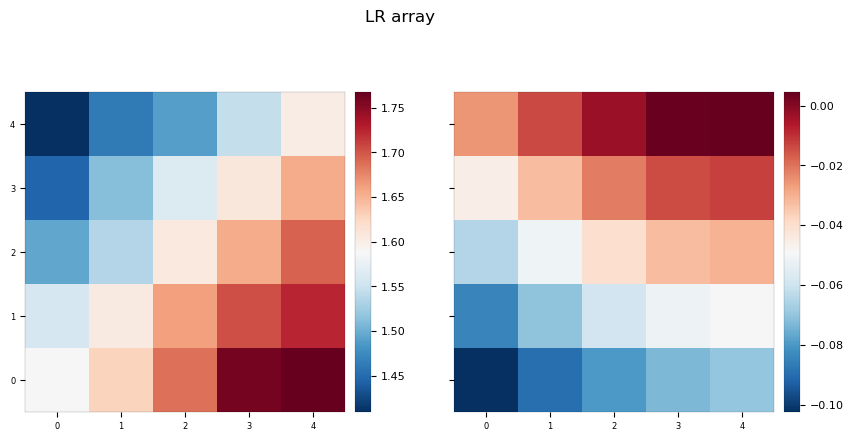

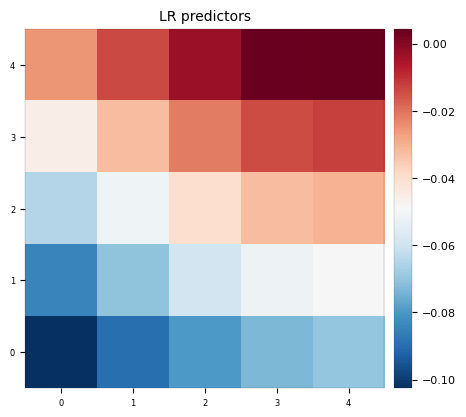

In [14]:
_ = dds.create_pair_hr_lr(y_train.values[0], None, 'spc', 4, None, None, y_z_train.values[0], None, True, interpolation='inter_area')

# Training Model

Possible backbones:
* resnet: MAE = 0.09434913098812103
* densenet: MAE = 0.04823455959558487 **best**
* convnet: MAE = 0.4711471498012543
* convnext: MAE = doesn't work

Running model with backbone=resnet
List of devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Number of devices: 1
Global batch size: 60
--------------------------------------------------------------------------------
Starting time: 2025-01-24 16:45:17
--------------------------------------------------------------------------------
Model: "resnet_spc"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                Output Shape                                 Param #        Connected to                                 
 input_2 (InputLayer)                        [(None, None, None, 1)]                      0              []                                           
                                                                                                                                                      
 conv2d_24 (Conv2

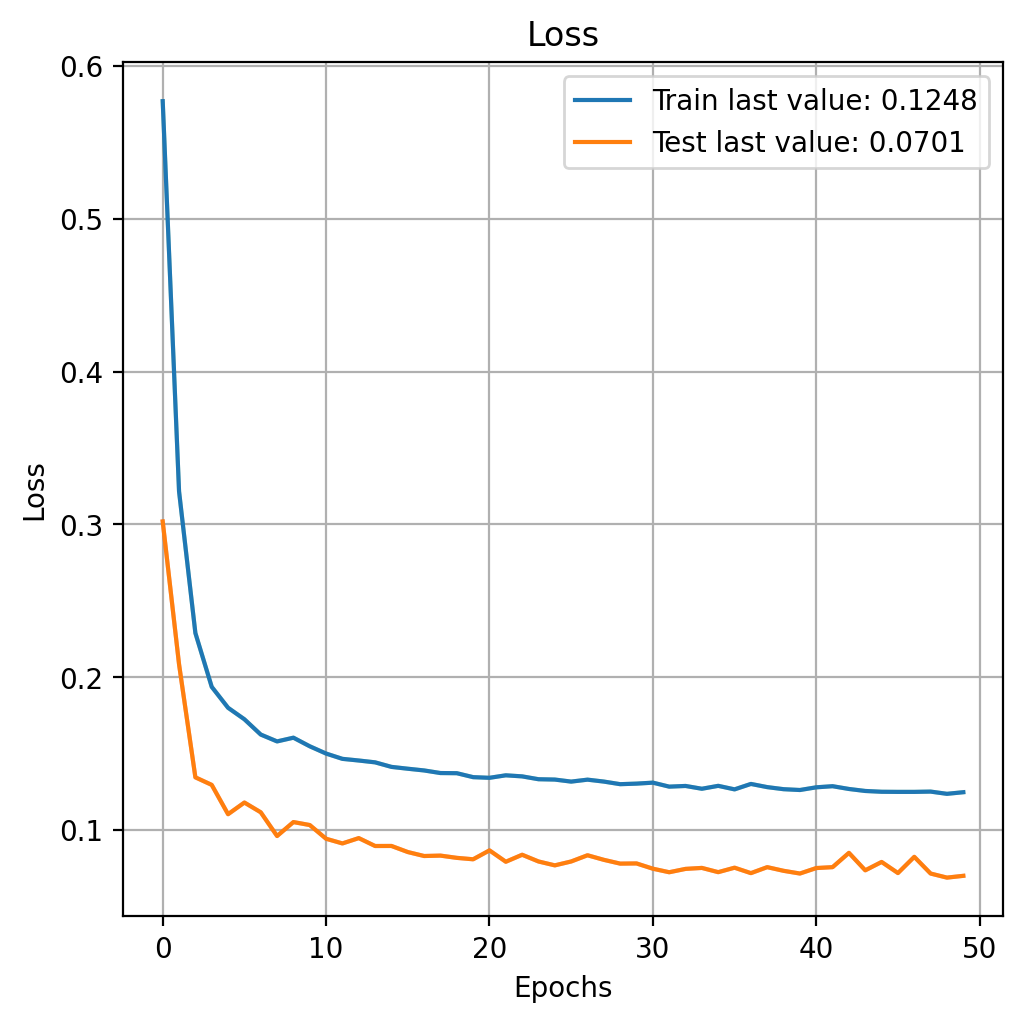

In [16]:
results = []
backbones = ['resnet']
for backbone in backbones:

    print(f"Running model with backbone={backbone}")
    
    ARCH_PARAMS = dict(n_filters=8,
                       n_blocks=4,
                       normalization=None,
                       dropout_rate=0.5,
                       dropout_variant='spatial',
                       attention=False,
                       activation='relu',
                       localcon_layer=False)
        
    trainer = dds.SupervisedTrainer(
            backbone=backbone,
            upsampling='spc', 
            data_train=y_train,
            data_val=y_val,
            data_test=y_test,
            data_train_lr=None, # here you can pass the LR dataset for training with explicit paired samples
            data_val_lr=None, # here you cxan pass the LR dataset for training with explicit paired samples
            data_test_lr=None, # here you can pass the LR dataset for training with explicit paired samples
            scale=4, 
            time_window=None, 
            static_vars=None,
            predictors_train=None,
            predictors_val=None,
            predictors_test=None,
            interpolation='inter_area',
            patch_size=None, 
            batch_size=60,
            loss='mae',
            epochs=50, 
            steps_per_epoch=None, 
            validation_steps=None, 
            test_steps=None, 
            learning_rate=(1e-3, 1e-4), lr_decay_after=1e4,
            early_stopping=False, patience=6, min_delta=0, 
           save=True, 
            save_bestmodel=True,
            save_path='/home/gvaillant1/downscaling/results/T2-NYC-Model',
            show_plot=True, verbose=True, 
            device='CPU',
            **ARCH_PARAMS)        

    trainer.run()
        


# Inference on uWRF test set

In [17]:
pred = dds.Predictor(
    trainer, 
    y_test, 
    scale=4, 
    array_in_hr=True,
    static_vars=None, 
    predictors=None, 
    time_window=None,
    interpolation='inter_area', 
    batch_size=60,
    scaler=T2_scaler_train,
    save_path=None,
    save_fname=None,
    return_lr=True,
    device='CPU')

unscaled_y_pred, coarsened_array = pred.run()

--------------------------------------------------------------------------------
Starting time: 2025-01-24 16:50:33
--------------------------------------------------------------------------------
14/14 [==============================] - 1s 14ms/step
--------------------------------------------------------------------------------
Final running time: 0:00:00.658755
--------------------------------------------------------------------------------


# Inference on NAM

In [18]:
pred1 = dds.Predictor(
    trainer, 
    x_train, 
    scale=4, 
    array_in_hr=False,
    static_vars=None, 
    predictors=None, 
    time_window=None,
    interpolation='inter_area', 
    batch_size=4,
    scaler=T2_scaler_train,
    save_path=None,
    save_fname=None,
    return_lr=True,
    device='CPU')

unscaled_x_pred, coarsened_array1 = pred1.run()

--------------------------------------------------------------------------------
Starting time: 2025-01-24 16:53:52
--------------------------------------------------------------------------------
385/385 [==============================] - 1s 3ms/step
--------------------------------------------------------------------------------
Final running time: 0:00:01.546923
--------------------------------------------------------------------------------


# Comparing predictions on uWRF test set

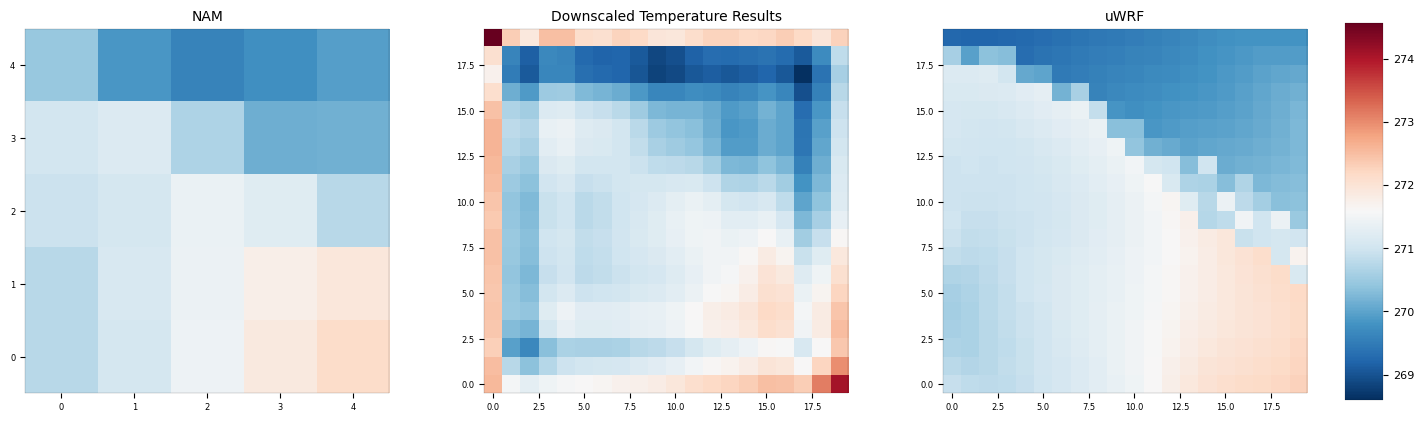

MAE for test set: 0.1495216339826584
<class 'xarray.core.dataarray.DataArray'>
<class 'numpy.ndarray'>
<class 'xarray.core.dataarray.DataArray'>


In [24]:
import cartopy.crs as crs
unscaled_x_test = T2_scaler_train.inverse_transform(x_test)
unscaled_y_test = T2_scaler_train.inverse_transform(y_test)
ecv.plot((unscaled_x_test[100].values, unscaled_y_pred[100], unscaled_y_test[100].values),
         cmap='RdBu_r', show_coastline=True, interactive=False, share_colorbar=True,
         #wanted_projection = crs.PlateCarree(), data_projection = crs.PlateCarree(),
         share_dynamic_range=True, subplot_titles=('NAM', 'Downscaled Temperature Results', 'uWRF'))

mae = dds.losses.mae(unscaled_y_test[0].values, unscaled_y_pred[0])
print(f"MAE for test set: {mae}")


print(type(unscaled_x_test))
print(type(unscaled_y_pred))
print(type(unscaled_y_test))

# Comparing predictions on NAM data 

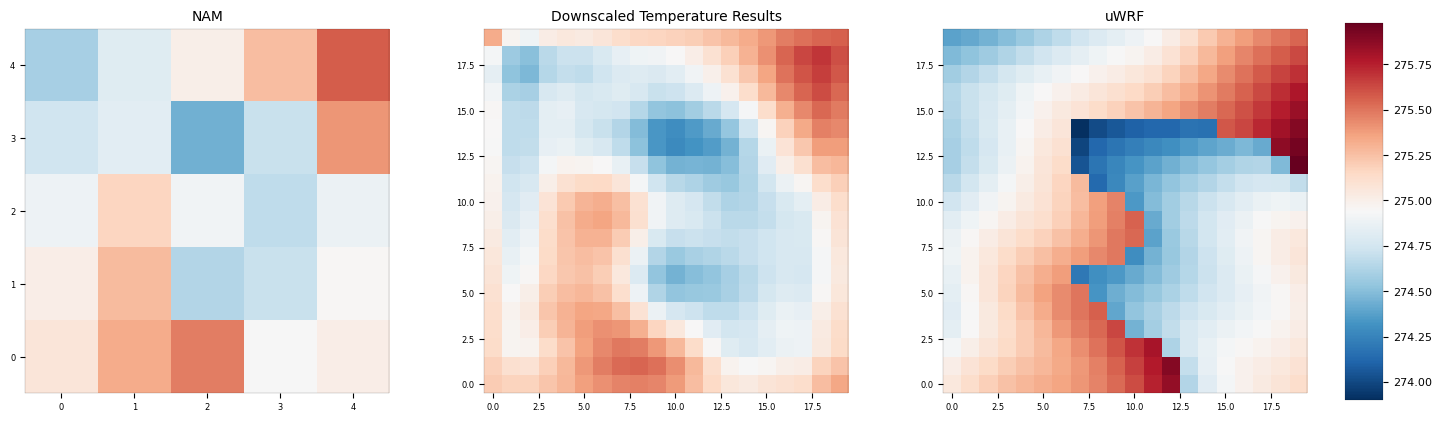

In [26]:
unscaled_y_train = T2_scaler_train.inverse_transform(y_train)
unscaled_x_train = T2_scaler_train.inverse_transform(x_train)
unscaled_y_test = T2_scaler_train.inverse_transform(y_test)
unscaled_x_test = T2_scaler_train.inverse_transform(x_test)
ecv.plot((unscaled_x_train[100].values, unscaled_x_pred[100], unscaled_y_train[100].values),
         share_colorbar=True, share_dynamic_range=True, subplot_titles=('NAM', 'Downscaled Temperature Results', 'uWRF'))

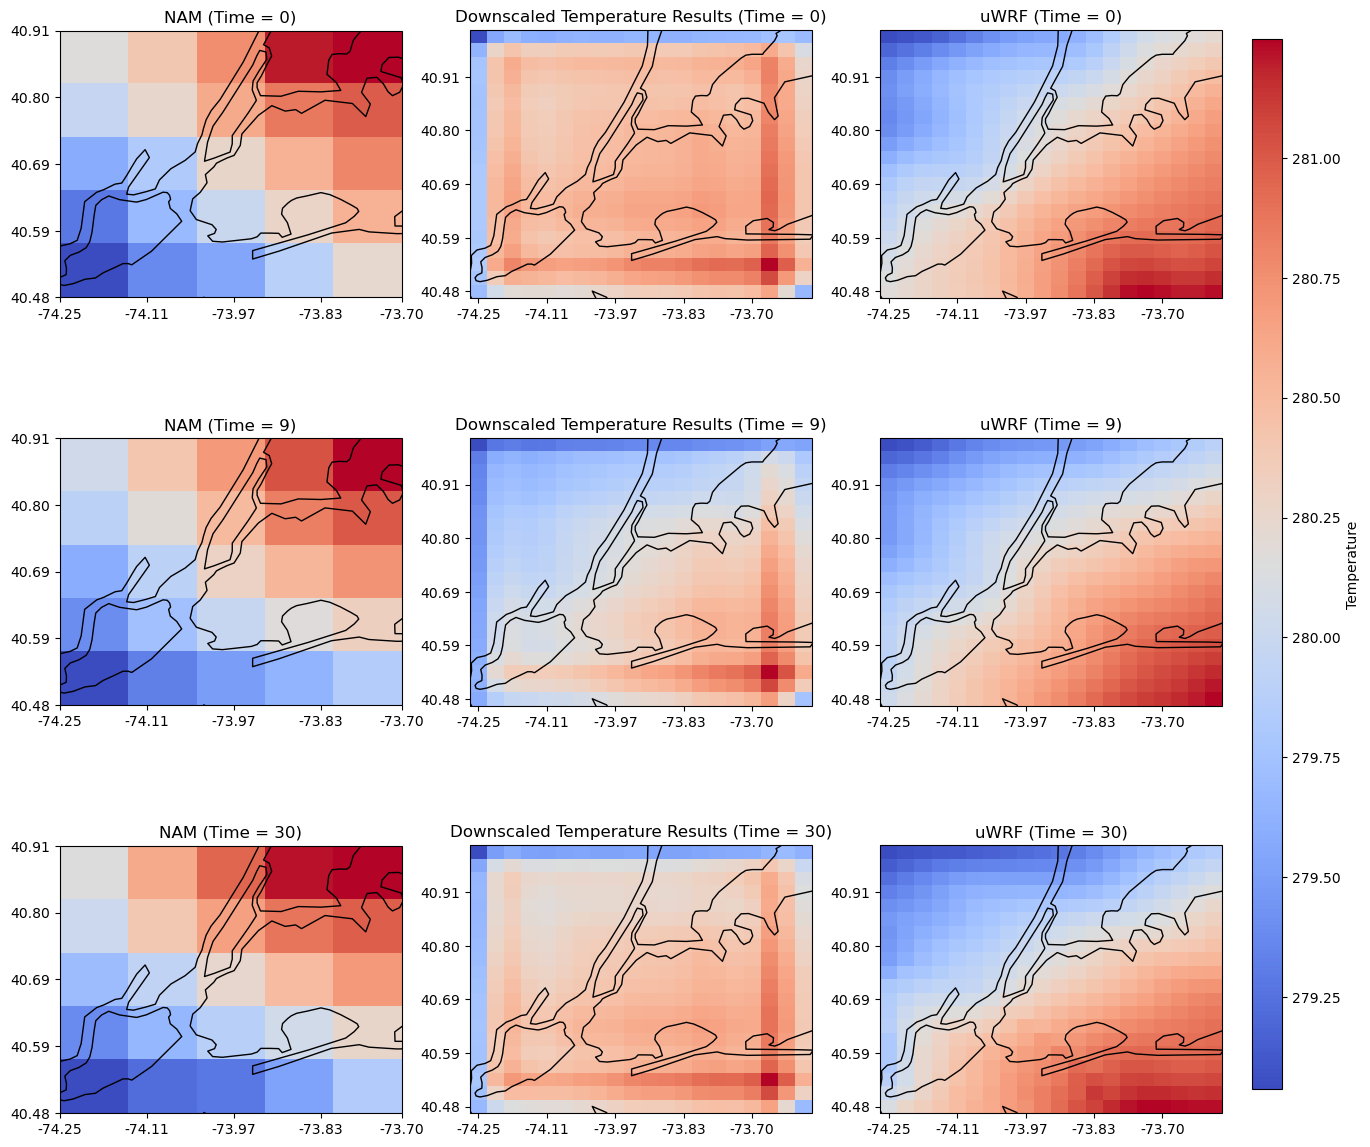

In [23]:
# Latitude and longitude for NAM
nam_lat = np.array([40.480194, 40.587536, 40.69487, 40.802197, 40.90954])
nam_lon = np.array([-74.25, -74.11, -73.97, -73.83, -73.7])

# Latitude and longitude for uWRF and downscaled data
uwrf_lat = np.array([
    40.480194, 40.507034, 40.53387, 40.5607, 40.587536, 40.614372,
    40.64121, 40.668037, 40.69487, 40.7217, 40.748535, 40.775364,
    40.802197, 40.829033, 40.85587, 40.882706, 40.90954, 40.93637,
    40.963203, 40.99004
])
uwrf_lon = np.array([
    -74.246155, -74.21185, -74.17755, -74.14325, -74.10895, -74.07468,
    -74.040405, -74.006165, -73.97189, -73.93765, -73.90341, -73.8692,
    -73.83496, -73.80078, -73.76657, -73.73239, -73.69821, -73.66403,
    -73.62988, -73.5957
])

# Create latitude-longitude meshgrids
nam_lon_grid, nam_lat_grid = np.meshgrid(nam_lon, nam_lat)
uwrf_lon_grid, uwrf_lat_grid = np.meshgrid(uwrf_lon, uwrf_lat)

# Dynamically set rows to match the number of time steps
time_steps = [0, 9, 30]
num_time_steps = len(time_steps)
fig, axes = plt.subplots(num_time_steps, 3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(15, 5 * num_time_steps))
titles = ['NAM', 'Downscaled Temperature Results', 'uWRF']

# Loop through time steps
for t_idx, i in enumerate(time_steps):
    # Extract data for the current time step
    nam_data = unscaled_x_train[i].values  # NAM data
    downscaled_data = unscaled_x_pred[i]  # Downscaled data
    uwrf_data = unscaled_y_train[i].values  # uWRF data

    # Loop through datasets for the current time step
    for j, (data, title) in enumerate(zip([nam_data, downscaled_data, uwrf_data], titles)):
        ax = axes[t_idx, j] if num_time_steps > 1 else axes[j]  # Handle single-row case
        
        if title == 'NAM':
            # Plot NAM data using imshow
            im = ax.imshow(data, extent=[nam_lon.min(), nam_lon.max(), nam_lat.min(), nam_lat.max()],
                           transform=ccrs.PlateCarree(), cmap='coolwarm', origin='upper')
        else:
            # Plot higher-resolution data using pcolormesh
            im = ax.pcolormesh(uwrf_lon_grid, uwrf_lat_grid, data, transform=ccrs.PlateCarree(), cmap='coolwarm')

        # Add coastlines and features
        ax.coastlines(resolution='10m', color='black')
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.set_title(f"{title} (Time = {i})")

        # Set axis ticks and labels
        if title == 'NAM':
            ax.set_xticks(nam_lon)
            ax.set_yticks(nam_lat)
        else:
            ax.set_xticks(uwrf_lon[::4])  # Reduce ticks for clarity
            ax.set_yticks(uwrf_lat[::4])  # Reduce ticks for clarity
        
        ax.set_xticklabels([f"{lon:.2f}" for lon in (nam_lon if title == 'NAM' else uwrf_lon[::4])])
        ax.set_yticklabels([f"{lat:.2f}" for lat in (nam_lat if title == 'NAM' else uwrf_lat[::4])])

# Add a single colorbar for all plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Colorbar position
fig.colorbar(im, cax=cbar_ax, label='Temperature')

# Save and show the plot
output_path = '/home/gvaillant1/downscaling/visualizations/T2-NYC-viz/T2_NYC_viz.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()


# Loss calculations

In [ ]:
mae = dds.losses.mae(unscaled_y_test[0], unscaled_y_pred[0])
print(f"MAE for training: {mae}")

mse = dds.losses.mse(unscaled_y_test[0], unscaled_y_pred[0])
print(f"MSE for training: {mse}")
print("")
mae_pred = dds.losses.mae(unscaled_y_test[0], unscaled_x_pred[0])
print(f"MAE on NAM: {mae_pred}")
mse_pred = dds.losses.mse(unscaled_y_test[0], unscaled_x_pred[0])
print(f"MSE on NAM: {mse_pred}")

print("")
if mae == mae_pred:
    print("Same MAE loss value for different unseen datasets.")
else:
    print("MAE loss is not the same")
    

if mse == mse_pred:
    print("Same MSE loss value for different unseen datasets :(")
else:
    print("MSE loss is not the same")

mae_for_preds = dds.losses.mae(unscaled_x_pred[0], unscaled_y_pred[0])
print("MAE between predictions, to see if they're exactly the same:")
print(f"MAE: {mae_for_preds}")